In [1]:
import os
import zarr
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import UNet_2D, aug
from src.utils import save_images
from src.metric import score, create_cls_pos, create_cls_pos_sikii, create_df
from metric import visualize_epoch_results

In [2]:
train_dataset = EziiDataset(
    exp_names=CFG.train_exp_names,
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.train_zarr_types,
)

valid_dataset = EziiDataset(
    exp_names=CFG.valid_exp_names,
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.valid_zarr_types,
)

from tqdm import tqdm

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
train_nshuffle_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

for data in tqdm(train_dataset):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

# normalized_tomogram =
normalized_tomogram.shape[0]

[('TS_5_4', 'denoised'), ('TS_73_6', 'denoised'), ('TS_99_9', 'denoised'), ('TS_6_4', 'denoised'), ('TS_69_2', 'denoised')]
[('TS_86_3', 'denoised'), ('TS_6_6', 'denoised')]


  0%|          | 0/5 [00:00<?, ?it/s]


92

In [3]:
import torch
import torchvision.transforms.functional as F
import random

Train-Epoch: 0, Loss: 1.074586543711749:  96%|█████████▌| 110/115 [00:20<00:00,  5.41it/s] 
Train-nshuffle-Epoch: 0, Loss: 0.9216963510798372: 100%|██████████| 460/460 [00:21<00:00, 21.76it/s]


####################### valid-experiments: TS_5_4 #######################
pred (92, 1, 7, 320, 320)
gt (92, 1, 320, 320)
####################### valid-experiments: TS_73_6 #######################
pred (92, 1, 7, 320, 320)
gt (92, 1, 320, 320)
####################### valid-experiments: TS_99_9 #######################
pred (92, 1, 7, 320, 320)
gt (92, 1, 320, 320)
####################### valid-experiments: TS_6_4 #######################
pred (92, 1, 7, 320, 320)
gt (92, 1, 320, 320)
####################### valid-experiments: TS_69_2 #######################
pred (92, 1, 7, 320, 320)
gt (92, 1, 320, 320)
EPOCH: 0, TRAIN_SCORE: 0.01101635476874269


Valid-Epoch: 0, Loss: 0.8168128449866112:  25%|██▌       | 46/184 [00:02<00:05, 25.09it/s] 

KeyboardInterrupt: 

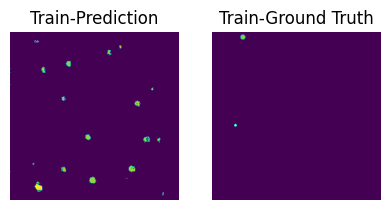

Valid-Epoch: 0, Loss: 0.8168128449866112:  26%|██▌       | 47/184 [00:20<00:05, 25.09it/s]

In [4]:
model = UNet_2D().to("cuda")
model.eval()


optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss(
    # weight=torch.tensor([0, 0.1000, 14.4163, 14.1303, 1.0000, 2.2055, 4.4967]).to(
    #     "cuda"
    # )
    weight=torch.tensor([0.5, 32, 32, 32, 32, 32, 32]).to("cuda")
)
# criterion = DiceLoss()

best_model = None
best_score = 0
batch_size = 4

for epoch in range(100):
    train_loss = []
    valid_loss = []
    train_pred_tomogram = defaultdict(list)
    train_gt_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)
    model.train()
    tq = tqdm(range(len(train_loader) * normalized_tomogram.shape[0] // batch_size))
    for data in train_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"]
        segmentation_map = data["segmentation_map"].long()

        for i in range(batch_size, tomogram.shape[1], batch_size):
            optimizer.zero_grad()
            from_, to_ = 0, tomogram.shape[1]
            random_index = random.sample(range(from_, to_), batch_size)
            input_ = tomogram[:, random_index]
            input_ = input_.permute(1, 0, 2, 3)  # (batch_size, 1, 160, 160)
            gt = segmentation_map[:, random_index].squeeze()  # (batch_size, 160, 160)

            # input_, gt = aug(input_, gt)

            input_ = input_.to("cuda")
            gt = gt.to("cuda")
            output = model(input_)
            loss = criterion(output, gt)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            tq.set_description(f"Train-Epoch: {epoch}, Loss: {np.mean(train_loss)}")
            tq.update(1)

    tq.close()

    ############################################# train-nshuffle #############################################
    model.eval()
    train_loss = []
    tq = tqdm(range(len(train_nshuffle_loader) * normalized_tomogram.shape[0]))
    for data in train_nshuffle_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            output = model(input_)
            loss = criterion(output, gt)

            train_loss.append(loss.item())
            tq.set_description(
                f"Train-nshuffle-Epoch: {epoch}, Loss: {np.mean(train_loss)}"
            )
            tq.update(1)

            train_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            train_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()

    train_score_ = visualize_epoch_results(
        train_pred_tomogram,
        train_gt_tomogram,
        sikii_dict=CFG.initial_sikii,
    )

    print(f"EPOCH: {epoch}, TRAIN_SCORE: {train_score_}")

    # 可視化
    index = 20

    plt.figure(figsize=(10, 5))

    ax = plt.subplot(1, 4, 1)
    ax.imshow(train_pred_tomogram[exp_name][index].squeeze(0).argmax(0))
    ax.set_title("Train-Prediction")
    ax.axis("off")

    ax = plt.subplot(1, 4, 2)
    ax.imshow(train_gt_tomogram[exp_name][index].squeeze(0))
    ax.set_title("Train-Ground Truth")
    ax.axis("off")

    ############################################# valid #############################################

    model.eval()
    tq = tqdm(range(len(valid_loader) * normalized_tomogram.shape[0]))
    for data in valid_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            output = model(input_)
            loss = criterion(output, gt)

            valid_loss.append(loss.item())
            tq.set_description(f"Valid-Epoch: {epoch}, Loss: {np.mean(valid_loss)}")
            tq.update(1)

            valid_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            valid_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()

    valid_score_ = visualize_epoch_results(
        valid_pred_tomogram,
        valid_gt_tomogram,
        sikii_dict=CFG.initial_sikii,
    )

    print(f"EPOCH: {epoch}, VALID_SCORE: {valid_score_}")

    if valid_score_ > best_score:
        best_score = valid_score_
        best_model = model
        torch.save(model.state_dict(), f"best_model.pth")

    ax = plt.subplot(1, 4, 3)
    ax.imshow(valid_pred_tomogram[exp_name][index].argmax(1).squeeze(0))
    ax.set_title("Valid-Prediction")
    ax.axis("off")

    ax = plt.subplot(1, 4, 4)
    ax.imshow(valid_gt_tomogram[exp_name][index].squeeze(0))
    ax.set_title("Valid-Ground Truth")
    ax.axis("off")

    plt.tight_layout()

    plt.show()

    # save_images(
    #     train_gt_tomogram=train_gt_tomogram,
    #     train_pred_tomogram=train_pred_tomogram,
    #     valid_gt_tomogram=valid_gt_tomogram,
    #     valid_pred_tomogram=valid_pred_tomogram,
    #     save_dir="images",
    #     epoch=epoch,
    # )

In [ ]:
train_pred_tomogram["TS_5_4"][index].squeeze(0).argmax(0).shape

In [ ]:
train_gt_tomogram["TS_5_4"][index].squeeze(0).shape

In [ ]:
# 可視化
index = 50

plt.figure(figsize=(10, 5))

# ax = plt.subplot(1, 4, 1)
# ax.imshow(train_pred_tomogram[exp_name][index].argmax(0))
# ax.set_title("Train-Prediction")
# ax.axis("off")

# ax = plt.subplot(1, 4, 2)
# ax.imshow(train_gt_tomogram[exp_name][index])
# ax.set_title("Train-Ground Truth")
# ax.axis("off")

ax = plt.subplot(1, 2, 1)
ax.imshow(valid_pred_tomogram[exp_name][index].argmax(1).squeeze(0))
ax.set_title("Valid-Prediction")
ax.axis("off")

ax = plt.subplot(1, 2, 2)
ax.imshow(valid_gt_tomogram[exp_name][index].squeeze(0))
ax.set_title("Valid-Ground Truth")
ax.axis("off")

plt.tight_layout()

plt.show()

In [ ]:
train_score_ = visualize_epoch_results(
    train_pred_tomogram,
    train_gt_tomogram,
    sikii_dict=CFG.initial_sikii,
)

print(f"EPOCH: {epoch}, VALID_SCORE: {train_score_}")